##Models of autocratic regime failure

This repository hosts several Python and R scripts for feature engineering, imputation, analysis, and visualization related to the analysis of authoritarian regime breakdown and democratic transition. The analysis is focused on the spillover effects of regime failures on future regime failures abroad, where the influence is captured by various operationalizations of *distance*, including geographic, linguistic, and economic distances between countries. 

The code in this repository uses [regime data from Geddes, Wright, and Frantz](http://dictators.la.psu.edu/ 'Autocratic Regimes') to construct spatiotemporal lags of regime failure. A demonstration of the procedure to construct these lags is in the [IPython Notebook titled `space_time_lags.ipynb`](https://github.com/thomasbrawner/regime_failure/blob/master/space_time_lags.ipynb). Missing data are imputed with the [Amelia II library in R](http://gking.harvard.edu/amelia 'Amelia II: A Program for Missing Data'). The main programs for carrying out the analysis are located in the Python file [`dissertation.py`](https://github.com/thomasbrawner/regime_failure/blob/master/dissertation.py), which formats the imputed data sets for analysis, performs rolling cross-validation over years to optimize hyperparameters for the classifiers, and aggregates the performance of the models over imputations. 

To demonstrate the analysis, below I present a model of autocratic failure as a function of the spatiotemporal lag of autocratic failures weighted by geographic distance. In this example I use a logistic regression model with $L2$ regularization. Start by importing modules and defining some helper functions for reading and formatting the imputed data sets. 

In [1]:
from __future__ import print_function
%matplotlib inline 
import dissertation as diss
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
sns.set_style('whitegrid') 


def prepare_data(file_path, dep_var, lag_var, factors, scale=False): 
    df = pd.read_table(file_path, sep=',', index_col=0)
    df = diss.DataFormatter(df, depvar=dep_var)
    df.set_specification(lag=lag_var, factors=factors)
    df.format_features(scale=scale)
    return df

def make_file_path(number): 
    return 'clean_data/imputation_{0}.csv'.format(str(number))

Read and format each of the imputed data sets, setting the specification for the model of autocratic failure with the spatiotemporal lag of autocratic failures (weighted by geographic distance). 

In [2]:
data_list = [prepare_data(file_path=make_file_path(i), 
                          dep_var='failure', 
                          lag_var='failure_failure_geographic_lag', 
                          factors=['region_', 'period_'], 
                          scale=True)
             for i in xrange(1, 11)]

Again, the classifier used in this example is logistic regression with $L2$ regularization. As such, we want an instance of this classifier from **`sklearn`** and a dictionary of hyperparameters over which to optimize performance, in this case $C$. The default setting is to optimize parameters with respect to area under the ROC curve.

In the end, we define an instance of the `Melder` class, which is the primary program for performing the analysis. Its function is to determine optimal classifier parameterization and then evaluate model performance across the imputed data sets. We pass the list of formatted imputed data sets along with the classifier and parameters to instantiate. 

In [3]:
ridge = LogisticRegression(penalty='l2')
params = {'C' : np.logspace(-3, -1)}
melder = diss.Melder(data_list, ridge, params)

Now we want to evaluate the optimal parameterization for each of the imputed data sets, as follows. 

In [4]:
%%capture
melder.evaluate_models(); 

[************************************************************************]100% 


We can see the optimal level of regularization for each of these models. 

In [5]:
[print(melder.model_evaluations[i].optimal_params) for i in xrange(len(data_list))]; 

{'C': 0.039069399370546147}
{'C': 0.091029817799152174}
{'C': 0.082864277285468427}
{'C': 0.10000000000000001}
{'C': 0.091029817799152174}
{'C': 0.10000000000000001}
{'C': 0.0625055192527397}
{'C': 0.10000000000000001}
{'C': 0.068664884500429985}
{'C': 0.0517947467923121}


Having done this, we can combine the predicted probabilities from the optimized models fit on each of the imputations. 

In [6]:
%%capture
predictions = melder.meld_predictions(); 

[************************************************************************]100% 


Which we can then visualize in histogram. 

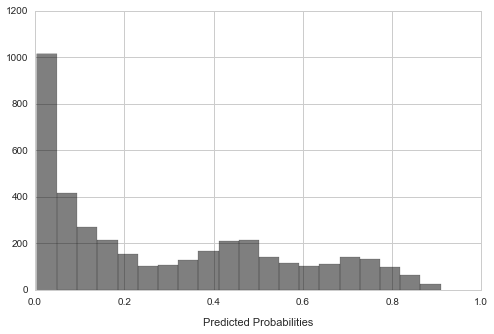

In [7]:
plt.figure(figsize=(8,5))
plt.hist(predictions, bins=20, alpha=0.5, color='k')
plt.xlabel('Predicted Probabilities', labelpad=11); 

Finally, we can extract and visualize the coefficient estimates averaged across the models. The sampling distribution for the estimates is obtained by evaluating the model on 100 bootstrap samples drawn from each of the ten imputed data sets, resulting in 1000 estimates. 

In [8]:
%%capture
boot_estimates = melder.meld_estimates(); 

[************************************************************************]100% 


In place of a regression table with coefficient estimates and standard errors, I present these results with boxplots of the 1000 bootstrap estimates for each of the key variables in the model. Notably, I suppress the estimates for region and two-year period dummies. 

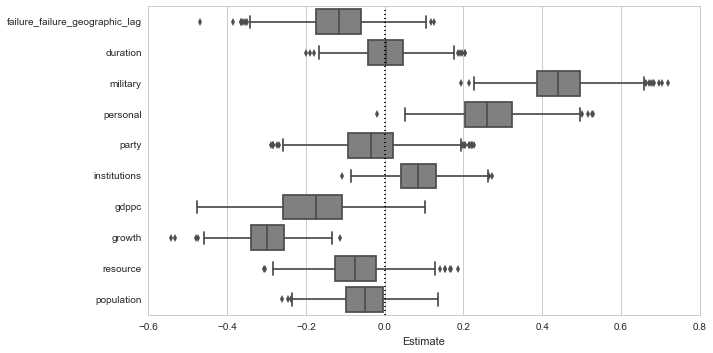

In [9]:
names = data_list[0].specification
plt.figure(figsize=(10, 5))
diss.boxplot_estimates(boot_estimates, names, ignore=['region_', 'period_'])